In [10]:
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
from EmotionCLIP_V2 import EmotionCLIP
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [ ]:

# Load the Artemis test data
artemis_df = pd.read_csv("data/artemis-v2/dataset/combined/train/artemis_per_image_weighted.csv")
test_df = artemis_df[artemis_df['split'] == 'test']
test_df.head()

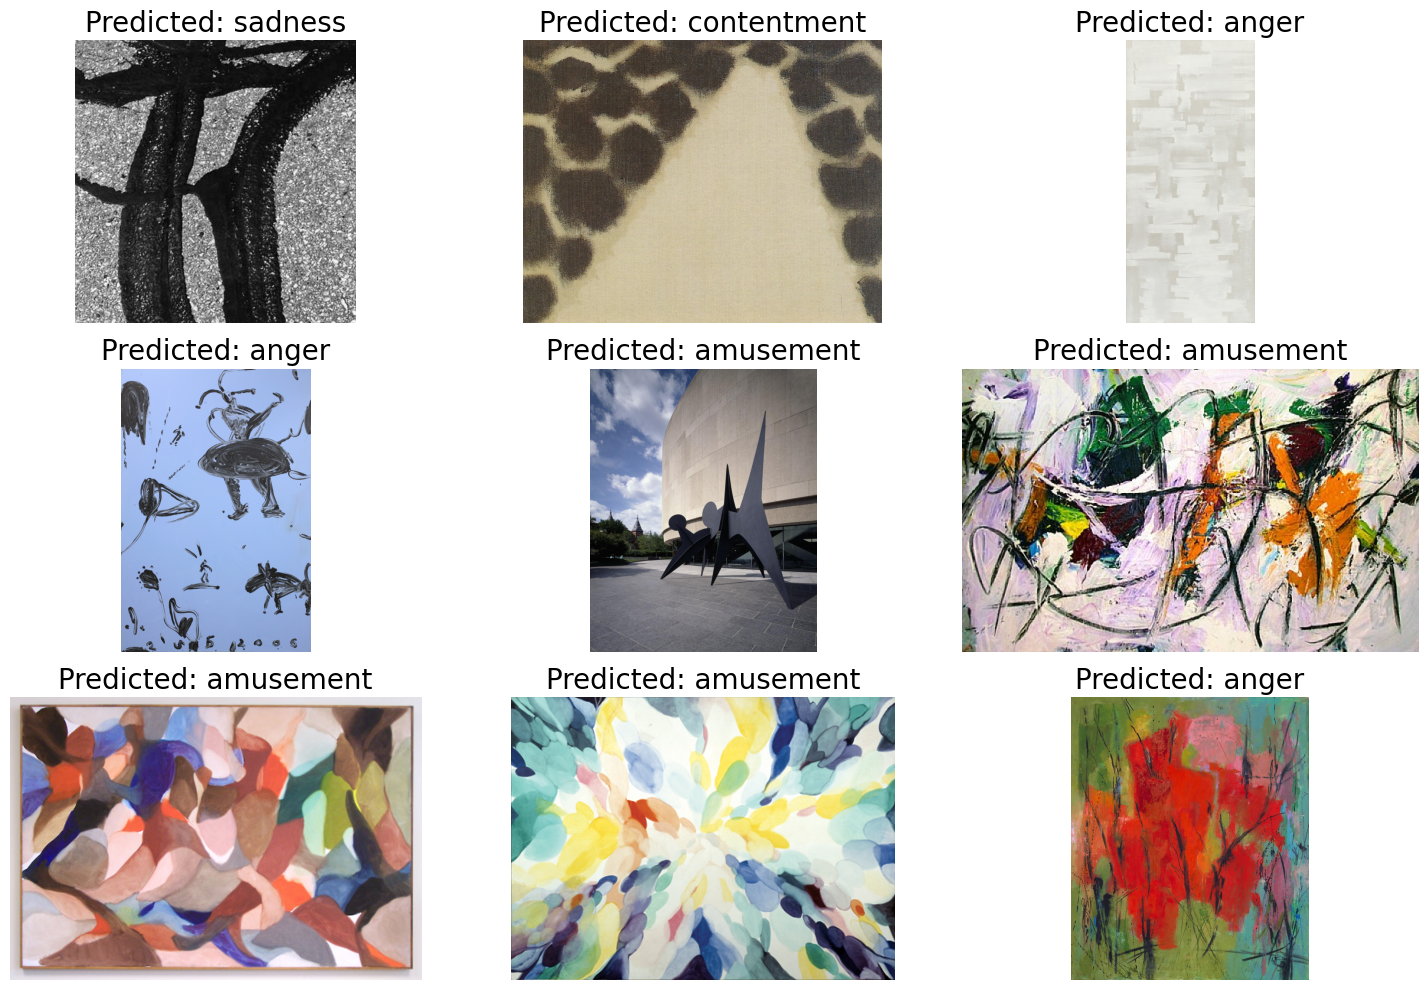

In [ ]:
model = EmotionCLIP.model
preprocess = EmotionCLIP.preprocess
tokenizer = EmotionCLIP.tokenizer

# Image folder path
image_files = test_df['image_file'].tolist()[:9]

# Emotion label mapping
consist_json = {
    'amusement': 0,
    'anger': 1,
    'awe': 2,
    'contentment': 3,
    'disgust': 4,
    'excitement': 5,
    'fear': 6,
    'sadness': 7,
    'something else': 8
}
reversal_json = {v: k for k, v in consist_json.items()}
text_list = [f"This picture conveys a sense of {key}" for key in consist_json.keys()]
text_input = tokenizer(text_list)

# Create subplots
num_images = len(image_files)
rows = 3  # 3 rows
cols = 3  # 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust the canvas size
axes = axes.flatten()  # Flatten the subplots to a 1D array
title_fontsize = 20

# Iterate through each image
for idx, img_path in enumerate(image_files):
    # Load image
    img = Image.open(img_path)
    img_input = preprocess(img)

    # Predict emotion
    with torch.no_grad():
        logits_per_image, _ = model(img_input.unsqueeze(0).to(device=model.device, dtype=model.dtype), text_input.to(device=model.device))
    softmax_logits_per_image = F.softmax(logits_per_image, dim=-1)
    top_k_values, top_k_indexes = torch.topk(softmax_logits_per_image, k=1, dim=-1)
    predicted_emotion = reversal_json[top_k_indexes.item()]

    # Display image and prediction result
    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(f"Predicted: {predicted_emotion}", fontsize=title_fontsize)
    ax.axis('off')

# Hide any extra subplots
for idx in range(num_images, rows * cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
CURRENT_TIME = time.strftime("%Y-%m-%d_%H-%M-%S")

# Create results folder if it doesn't exist
results_dir = "results"
figures_dir = "figures"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Process all test images
print(f"Starting to process {len(test_df)} images...")
results = []
batch_size = 32  # Adjust based on your system's memory
start_time = time.time()

# Process in batches
for i in range(0, len(test_df), batch_size):
    batch = test_df.iloc[i:i+batch_size]
    
    # Process each image in the batch
    for idx, row in tqdm(batch.iterrows(), total=len(batch), desc=f"Batch {i//batch_size + 1}/{(len(test_df)-1)//batch_size + 1}"):
        img_path = row['image_file']
            
        try:
            # Load and preprocess image
            img = Image.open(img_path).convert('RGB')
            img_input = preprocess(img)
            
            # Predict emotion
            with torch.no_grad():
                logits_per_image, _ = model(
                    img_input.unsqueeze(0).to(device=model.device, dtype=model.dtype), 
                    text_input.to(device=model.device)
                )
                
            # Get probabilities
            probs = F.softmax(logits_per_image, dim=-1).squeeze().cpu().numpy()
            
            # Get top prediction
            top_idx = probs.argmax()
            predicted_emotion = reversal_json[top_idx]
            confidence = probs[top_idx]
            
            # Store results
            results.append({
                'image_path': img_path,
                'predicted_emotion': predicted_emotion,
                'emotion_logits': probs.tolist(),
                'confidence': confidence,
                'error': None,
                'art_style': row.get('art_style', None),
                'painting': row.get('painting', None)
            })
            
        except Exception as e:
            results.append({
                'image_path': img_path,
                'predicted_emotion': None,
                'emotion_logits': None,
                'confidence': None,
                'error': str(e)
            })

processing_time = time.time() - start_time
print(f"Processing completed in {processing_time:.2f} seconds ({processing_time/60:.2f} minutes)")

# 3. Convert results to DataFrame and save
results_df = pd.DataFrame(results)
print(f"Processed {len(results_df)} images")
print(f"Successfully processed: {len(results_df[results_df['error'].isna()])} images")
print(f"Failed: {len(results_df[results_df['error'].notna()])} images")

# 4. Merge with the original test_df to get artwork metadata
merged_df = test_df.merge(results_df, left_on='image_file', right_on='image_path', how='left')

# 5. Save the full results
merged_df.to_csv(f'{results_dir}/artemis_emotionclip_predictions.csv', index=False)
print(f"Full results saved to {results_dir}/artemis_emotionclip_predictions.csv")

# 6. Calculate and visualize emotion distribution
emotion_counts = results_df['predicted_emotion'].value_counts()
emotion_percentages = results_df['predicted_emotion'].value_counts(normalize=True) * 100

# Save distribution data
distribution_df = pd.DataFrame({
    'emotion': emotion_counts.index,
    'count': emotion_counts.values,
    'percentage': emotion_percentages.values
})
distribution_df.to_csv(f'{results_dir}/emotion_distribution_CLIP_{CURRENT_TIME}.csv', index=False)
print(f"Emotion distribution saved to {results_dir}/emotion_distribution_CLIP_{CURRENT_TIME}.csv")

# 7. Create and save distribution visualizations
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Predicted Emotions in Artemis Dataset', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

# Add count and percentage labels on bars
for i, (count, percentage) in enumerate(zip(emotion_counts.values, emotion_percentages.values)):
    ax.text(i, count + 50, f"{count}\n({percentage:.1f}%)", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{figures_dir}/emotion_distribution_bar_CLIP_{CURRENT_TIME}.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Create and save pie chart
plt.figure(figsize=(10, 10))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05]*len(emotion_counts),
        colors=sns.color_palette('viridis', len(emotion_counts)))
plt.title('Percentage Distribution of Predicted Emotions', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig(f'{figures_dir}/emotion_distribution_pie_CLIP_{CURRENT_TIME}.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Create and save distribution by art style (top 10 styles)
if 'art_style' in merged_df.columns:
    # Group by art style and predicted emotion
    style_emotion = merged_df.groupby(['art_style', 'predicted_emotion']).size().unstack().fillna(0)
    
    # Get top 10 styles by total count
    top_styles = style_emotion.sum(axis=1).sort_values(descending=True).head(10).index
    top_style_emotion = style_emotion.loc[top_styles]
    
    # Plot and save
    plt.figure(figsize=(16, 10))
    top_style_emotion.plot(kind='bar', stacked=True, colormap='viridis', figsize=(16, 10))
    plt.title('Emotion Distribution by Art Style (Top 10)', fontsize=16)
    plt.xlabel('Art Style', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{figures_dir}/emotion_by_art_style_CLIP_{CURRENT_TIME}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save the data
    top_style_emotion.reset_index().to_csv(f'{results_dir}/emotion_by_art_style.csv')
    print(f"Emotion distribution by art style saved to {results_dir}/emotion_by_art_style.csv")

print("All results have been saved to the results folder!")